In this notebook, we model the chromatic beam using a combination of angular beam measurements and time domain simulations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import copy,csv
import scipy.signal as signal
import scipy.interpolate as interp
import scipy.optimize as op
import cosmology as cosmo

/Users/aaronew/default/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
planeWaveFeedAndDish=np.loadtxt('../data/feedSim_500ns_pW.txt',skiprows=2)
voltageResponseFeedAndDish=np.loadtxt('../data/feedSim_500ns_o1.txt',skiprows=2)

planeWaveFeedAndDishNS=np.loadtxt('../data/feedSim_noSkirt_1000ns_pw.txt',skiprows=2)
voltageResponseFeedAndDishNS=np.loadtxt('../data/feedSim_noSkirt_1000ns_o1.txt',skiprows=2)

planeWaveFeedAndDish20Deg=np.loadtxt('../data/PW20deg_pw.txt')
voltageResponseFeedAndDish20Deg=np.loadtxt('../data/PW20deg_o1.txt')


ntFeedAndDish20Deg=len(planeWaveFeedAndDish20Deg)
dtFeedAndDish20Deg=planeWaveFeedAndDish20Deg[1,0]-planeWaveFeedAndDish20Deg[0,0]
ntFeedAndDish=len(planeWaveFeedAndDish)
dtFeedAndDish=voltageResponseFeedAndDish[1,0]-voltageResponseFeedAndDish[0,0]
dtFeedAndDishNS=voltageResponseFeedAndDishNS[1,0]-voltageResponseFeedAndDishNS[0,0]
ntFeedAndDishNS=len(planeWaveFeedAndDishNS)

In [3]:
#delay trace of zenith pointing
pwPadFeedAndDish=np.pad(planeWaveFeedAndDish[:,1],(ntFeedAndDish*.5,ntFeedAndDish*.5),mode='constant')
vrPadFeedAndDish=np.pad(voltageResponseFeedAndDish[:,1],(ntFeedAndDish*.5,ntFeedAndDish*.5),mode='constant')
                        
fAxisPadFeedAndDish=(fft.fftfreq(len(vrPadFeedAndDish),dtFeedAndDish))
fWaveFeedAndDish=fft.fft(fft.fftshift(pwPadFeedAndDish))
fResponseFeedAndDish=fft.fft(fft.fftshift(vrPadFeedAndDish))
dfFeedAndDish=fAxisPadFeedAndDish[1]-fAxisPadFeedAndDish[0]

selectionPos=np.logical_and(fAxisPadFeedAndDish>=50./1e3,fAxisPadFeedAndDish<=250./1e3)
selectionNeg=np.logical_and(-fAxisPadFeedAndDish>=50./1e3,-fAxisPadFeedAndDish<=250./1e3)
nSelect=len(fAxisPadFeedAndDish[selectionPos])
print nSelect
windowFeedAndDish=np.hamming(nSelect)
#windowFeedAndDish=signal.blackmanharris(nSelect)
windowFeedAndDish=windowFeedAndDish/windowFeedAndDish.mean()
windowFeedAndDishFull=np.zeros(2*ntFeedAndDish)
windowFeedAndDishFull[selectionPos]=windowFeedAndDish
windowFeedAndDishFull[selectionNeg]=windowFeedAndDish
delayResponseFeedAndDish=fft.fftshift(fft.ifft(fft.fftshift((windowFeedAndDishFull*fResponseFeedAndDish/fWaveFeedAndDish)[selectionPos])))
tAxisFeedAndDish=fft.fftshift(fft.fftfreq(len(delayResponseFeedAndDish),dfFeedAndDish))

204


In [4]:
#delay trace of sidelobe
pwPadFeedAndDish20Deg=np.pad(planeWaveFeedAndDish20Deg[:,1],(ntFeedAndDish20Deg*.5,ntFeedAndDish20Deg*.5),mode='constant')
vrPadFeedAndDish20Deg=np.pad(voltageResponseFeedAndDish20Deg[:,1],(ntFeedAndDish20Deg*.5,ntFeedAndDish20Deg*0.5),mode='constant')
                        
fAxisPadFeedAndDish20Deg=(fft.fftfreq(len(vrPadFeedAndDish20Deg),dtFeedAndDish20Deg))
fWaveFeedAndDish20Deg=fft.fft(fft.fftshift(pwPadFeedAndDish20Deg))
fResponseFeedAndDish20Deg=fft.fft(fft.fftshift(vrPadFeedAndDish20Deg))
dfFeedAndDish20Deg=fAxisPadFeedAndDish20Deg[1]-fAxisPadFeedAndDish20Deg[0]

selectionPos=np.logical_and(fAxisPadFeedAndDish20Deg>=50./1e3,fAxisPadFeedAndDish20Deg<=250./1e3)
selectionNeg=np.logical_and(-fAxisPadFeedAndDish20Deg>=50./1e3,-fAxisPadFeedAndDish20Deg<=250./1e3)
nSelect=len(fAxisPadFeedAndDish20Deg[selectionPos])
print nSelect
windowFeedAndDish20Deg=np.hamming(nSelect)
#windowFeedAndDish=signal.blackmanharris(nSelect)
windowFeedAndDish20Deg=windowFeedAndDish20Deg/windowFeedAndDish20Deg.mean()
windowFeedAndDishFull20Deg=np.zeros(ntFeedAndDish20Deg*2)
windowFeedAndDishFull20Deg[selectionPos]=windowFeedAndDish20Deg
windowFeedAndDishFull20Deg[selectionNeg]=windowFeedAndDish20Deg
delayResponseFeedAndDish20Deg=fft.fftshift(fft.ifft(fft.fftshift((windowFeedAndDishFull20Deg*fResponseFeedAndDish20Deg/fWaveFeedAndDish20Deg)[selectionPos])))
tAxisFeedAndDish20Deg=fft.fftshift(fft.fftfreq(len(delayResponseFeedAndDish20Deg),dfFeedAndDish20Deg))

215


In [5]:
def pivotFunc(x,a,b,c):
    xbelow=x<c
    xabove=x>=c
    output=np.zeros(len(x))
    output[xbelow]=a**x[xbelow]
    output[xabove]=(a**c)*b**(x[xabove])
    return output

In [6]:
def pivotFuncLog(x,a,b,c):
    xbelow=x<c
    xabove=x>=c
    output=np.zeros(len(x))
    output[xbelow]=np.log10(a)*x[xbelow]
    output[xabove]=np.log10(a)*c+np.log10(b)*(x[xabove]-c)
    return output

[  0.92727325   0.98658702  70.21497865]
[  0.94658355   0.98794711  65.54491798]


(-100, 10)

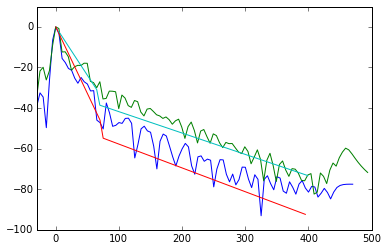

In [10]:
nVal=np.abs(delayResponseFeedAndDish).max()
nVal20=np.abs(delayResponseFeedAndDish20Deg).max()


plt.plot(tAxisFeedAndDish-35,20*np.log10(np.abs(delayResponseFeedAndDish)/nVal))
plt.plot(tAxisFeedAndDish20Deg-40,20*np.log10(np.abs(delayResponseFeedAndDish20Deg)/nVal20))

#fit to line
fitfunc = lambda x,a,b: a*x+b

selZ=np.logical_and(tAxisFeedAndDish-35.>=0.,tAxisFeedAndDish-35.<=400.)
fParams,_=op.curve_fit(pivotFuncLog,tAxisFeedAndDish[selZ]-35.,np.log10(np.abs(delayResponseFeedAndDish[selZ])/nVal),p0=[1.,1.,20.])
sel20Deg=np.logical_and(tAxisFeedAndDish20Deg-40.>=0.,tAxisFeedAndDish20Deg-40.<=400.)
fParams20Deg,_=op.curve_fit(pivotFuncLog,tAxisFeedAndDish20Deg[sel20Deg]-35.,np.log10(np.abs(delayResponseFeedAndDish[sel20Deg])/nVal20),p0=[1.,1.,10.])



print fParams
print fParams20Deg

plt.plot((tAxisFeedAndDish[selZ]-35.),20*np.log10(np.abs(pivotFunc(tAxisFeedAndDish[selZ]-35.,fParams[0],fParams[1],fParams[2]))))
plt.plot((tAxisFeedAndDish20Deg[sel20Deg]-40.),20*np.log10(np.abs(pivotFunc(tAxisFeedAndDish20Deg[sel20Deg]-40.,fParams20Deg[0],fParams20Deg[1],fParams20Deg[2]))))

#lets try a simple linear fit to the response

def paramFunc(polarAngle):
    a=(fParams20Deg[0]-fParams[0])/20.*polarAngle+fParams[0]
    b=(fParams20Deg[1]-fParams[0])/20.*polarAngle+fParams[1]
    c=(fParams20Deg[2]-fParams[2])/20.*polarAngle+fParams[2]
    return (a,b,c)
    
#for pAngle in [0.,0]:
    plt.plot(tAxisFeedAndDish[selZ]-35.,20.*np.log10(np.abs(pivotFunc(tAxisFeedAndDish[selZ]-35.,*paramFunc(pAngle)))))

plt.xlim(-30,500)
plt.ylim(-100,10)

[  0.92727325   0.98658702  70.21497865]
[  0.94658355   0.98794711  65.54491798]


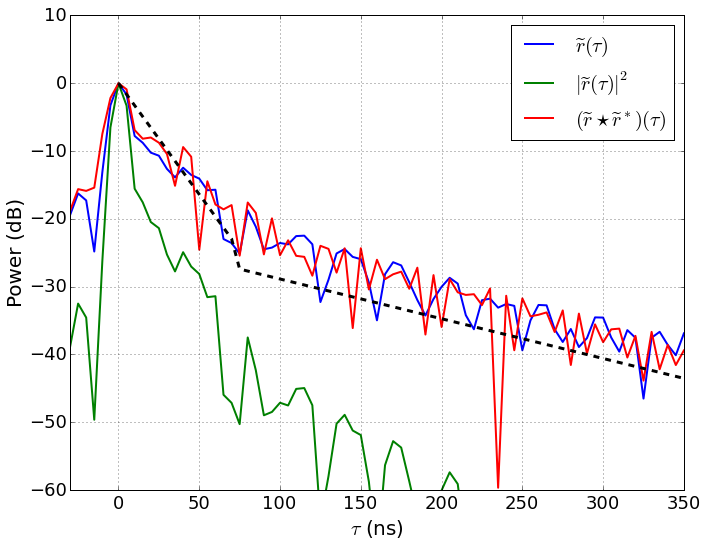

In [40]:
nVal=np.abs(delayResponseFeedAndDish).max()
nVal20=np.abs(delayResponseFeedAndDish20Deg).max()

powerKernelFeedAndDish=signal.convolve(delayResponseFeedAndDish,np.conj(delayResponseFeedAndDish),mode='same')
nValP=np.abs(powerKernelFeedAndDish).max()

plt.plot(tAxisFeedAndDish-35,10*np.log10(np.abs(delayResponseFeedAndDish)/nVal),label='$\\widetilde{r}(\\tau)$',lw=2)
plt.plot(tAxisFeedAndDish-35,20*np.log10(np.abs(delayResponseFeedAndDish)/nVal),label='$|\\widetilde{r}(\\tau)|^2$',lw=2)
plt.plot(tAxisFeedAndDish-75,10*np.log10(np.abs(powerKernelFeedAndDish)/nValP),label='$(\\widetilde{r}\\star\\widetilde{r}^*)(\\tau)$',lw=2)


#fit to line
fitfunc = lambda x,a,b: a*x+b

selZ=np.logical_and(tAxisFeedAndDish-35.>=0.,tAxisFeedAndDish-35.<=400.)
fParams,_=op.curve_fit(pivotFuncLog,tAxisFeedAndDish[selZ]-35.,np.log10(np.abs(delayResponseFeedAndDish[selZ])/nVal),p0=[1.,1.,20.])

print fParams
print fParams20Deg

plt.plot((tAxisFeedAndDish[selZ]-35.),10*np.log10(np.abs(pivotFunc(tAxisFeedAndDish[selZ]-35.,fParams[0],fParams[1],fParams[2]))),color='k',ls='--',lw=3)

#lets try a simple linear fit to the response

def paramFunc(polarAngle):
    a=(fParams20Deg[0]-fParams[0])/20.*polarAngle+fParams[0]
    b=(fParams20Deg[1]-fParams[0])/20.*polarAngle+fParams[1]
    c=(fParams20Deg[2]-fParams[2])/20.*polarAngle+fParams[2]
    return (a,b,c)


plt.grid()
plt.xlim(-30,350)
plt.ylim(-60,10)
plt.ylabel('Power (dB)',fontsize=20)
plt.xlabel('$\\tau$ (ns)',fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.gca().tick_params('x',labelsize=18)
plt.gca().tick_params('y',labelsize=18)
plt.gcf().set_size_inches(11,8.5)
plt.savefig('../paper/figures/convolveCompare.pdf')

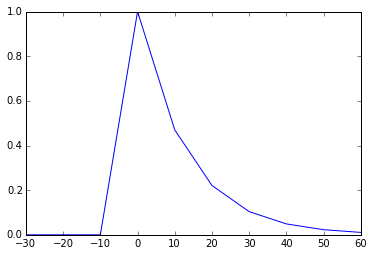

In [8]:
df=100e3
band=100e6
dT=1/band
nT=int(band/df)
if(np.mod(nT,2)==1):
    nT+=2
    
tFull=np.arange(-nT/2,nT/2)*dT
delayBand=np.zeros(len(tFull))
delayBand[tFull>=0]=pivotFunc(tFull[tFull>=0]*1e9,*fParams)
plt.plot(tFull*1e9,delayBand)
plt.xlim(-30,60)
fBand=fft.fftshift(fft.fft(fft.fftshift(delayBand)))
fAxis=fft.fftshift(fft.fftfreq(len(delayBand),tFull[1]-tFull[0]))

2500.0
1500


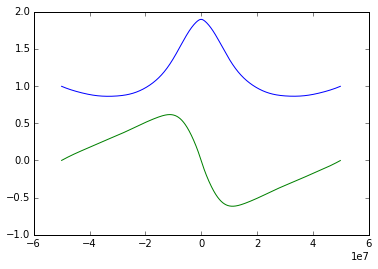

In [9]:
#generate 250MHz Hamming window
print len(fBand)*250./100.
wCorrect=np.hamming(int(len(fBand)*250./100.))
dFactor=len(wCorrect)-len(fBand)
print dFactor
wCorrect=wCorrect[dFactor/2:-dFactor/2]
plt.plot(fAxis,np.real(fBand/wCorrect))
plt.plot(fAxis,np.imag(fBand/wCorrect))